In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from model import BoltzmannBank
from agents import Individual, Bank, ReserveBank

# The Boltzmann Bank

## Overview

The following models are very simple simulations of economic activity. It comprises many independent agents, called 'individuals', that "spend" money by randomly giving some to another individual; the money an individual receives from others is its "income". There are no goods or services in these models, hence no employment nor supply and demand nor any prices at all. They are solely intended to simulate a realistic monetary system.

In these models, money takes the form of bank liabilities: each individual has an account with a bank, and when they give money to another individual, the bank simply adjusts the account balances accordingly. Consequently, the bank has the ability to create more money by issuing more liabilities, which is to say by issuing a loan.

---

In this agent-based model there are many `Individual`s and a single `Bank`. The `Bank` provides a means of payment that the `Individual`s can use as money. Each turn, each `Individual` wants to give one unit of money to another `Individual`. If they can't (because they don't have enough money) they can choose instead to apply for a loan from the `Bank` as long as they are beneath their personal borrowing limit; otherwise they do nothing.

If an `Individual` has a loan due (or overdue) on a step, they will try to repay it before giving anyone else money. If they do not have enough money, they will apply for a loan if they are beneath their borrowing limit; otherwise, they will do nothing and hope to repay the loan later. If they do have enough to repay the loan, they will repay it; if there is any money leftover, they will give a unit to someone else.

## Visualization

For each of the models below, we will want ot visualize some common data.

In [2]:
def plot_money_supply(model, period: int = 1):
    """Plot the money supply and its change over time, with separate visualization for issued and repaid debt.

    Parameters:
    -----------
    model : Mesa model
        The simulation model containing the collected data.
    period : int, optional (default=1)
        The number of steps to aggregate over. Used for rolling sums and downsampling.

    """
    # Extract model-level data
    model_df = model.datacollector.get_model_vars_dataframe()

    # Ensure necessary columns exist
    required_columns = {"Money Supply", "Issued Debt", "Repaid Debt"}
    missing = required_columns - set(model_df.columns)
    if missing:
        raise ValueError(f"Missing expected columns in model dataframe: {missing}")

    # Compute money supply change (Net Debt Issuance) as a rolling sum over the specified period
    model_df["Issued Debt"] = model_df["Issued Debt"].rolling(period).sum()
    model_df["Repaid Debt"] = model_df["Repaid Debt"].rolling(period).sum()
    model_df["Money Supply Change"] = model_df["Issued Debt"] - model_df["Repaid Debt"]

    # Downsample the data by selecting every 'period' step
    sampled_df = model_df.iloc[::period]

    # Create figure with two vertically stacked axes
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    ## **First Plot: Total Money Supply**
    axes[0].plot(sampled_df.index, sampled_df["Money Supply"], label="Money Supply", color="blue")
    axes[0].set_ylabel("Money Supply")
    axes[0].set_title(f"Money Supply Over Time (Downsampled every {period} steps)")
    axes[0].legend()

    ## **Second Plot: Issued Debt & Net Issuance**
    axes[1].plot(sampled_df.index, sampled_df["Money Supply Change"], label="Net Issuance", color="black")
    axes[1].plot(sampled_df.index, sampled_df["Issued Debt"], label="Issued Debt", color="black", linestyle="dashed")

    # **Shading between Issued Debt and Net Issuance ("Less Debt Repaid")**
    axes[1].fill_between(
        sampled_df.index,
        sampled_df["Issued Debt"],
        sampled_df["Money Supply Change"],
        interpolate=True,
        color="gray",
        alpha=0.3,
        label="Less Debt Repaid"
    )

    # **Shading for positive/negative net issuance**
    axes[1].fill_between(
        sampled_df.index,
        sampled_df["Money Supply Change"], 
        0,
        where=(sampled_df["Money Supply Change"] > 0),
        interpolate=True,
        color="green",
        alpha=0.3,
        label="Money Supply Growing"
    )

    axes[1].fill_between(
        sampled_df.index,
        sampled_df["Money Supply Change"], 
        0,
        where=(sampled_df["Money Supply Change"] < 0),
        interpolate=True,
        color="red",
        alpha=0.3,
        label="Money Supply Shrinking"
    )

    axes[1].set_ylabel(f"Change in Money Supply (Rolling {period}-Step Sum)")
    axes[1].set_xlabel("Steps")
    axes[1].set_title(f"Change in Money Supply Over Time (Rolling {period}-Step Sum)")
    axes[1].legend()

    # Improve layout and show plot
    plt.tight_layout()
    plt.show()

In [3]:
def plot_model_data(model):
    # extract the dataframe
    model_df = model.datacollector.get_model_vars_dataframe()

    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
    
    # first plot: the money supply
    sns.lineplot(data=model_df["Money Supply"], ax=axes[0])
    axes[0].set_ylabel("Money Supply")
    axes[0].set_ylim(0, model_df["Money Supply"].max() * 1.1)
    
    # second plot:
    sns.lineplot(data=model_df["Issued Debt"], ax=axes[1])
    axes[1].set_ylabel("Issued Debt")
    
    # third plot:
    sns.lineplot(data=model_df["Repaid Debt"], ax=axes[2])
    axes[2].set_ylabel("Repaid Debt")
    
    # fourth plot: total income
    sns.lineplot(data=model_df["Income"], ax=axes[3])
    axes[3].set_ylabel("Income")
    
    # fifth plot: total spending
    sns.lineplot(data=model_df["Spending"], ax=axes[4])
    axes[4].set_ylabel("Spending")
    
    # label for the common horizontal axis
    axes[4].set_xlabel("Steps")

    plt.tight_layout()
    plt.show();

def plot_individual_data(model):
    # extract dataframe
    individual_df = model.datacollector.get_agenttype_vars_dataframe(Individual).xs(model.steps, level="Step")

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
    
    # first plot: 
    sns.histplot(individual_df["Wealth"], discrete=True, ax=axes[0])
    axes[0].set_ylabel("Wealth (Count)")
    
    # second plot: 
    sns.histplot(individual_df["Income"], discrete=True, ax=axes[1])
    axes[1].set_ylabel("Income (Count)")
    
    # label for common horizontal axis
    axes[1].set_xlabel("Currency Units")
    
    plt.tight_layout()
    plt.show();


---

## 1. Base model: no loans

Let's start with a simulation without any loans. In this model, individuals will be gifted a specifiable amount of money when they first open their account (during the initialization of the model). After that, the only way individuals can get more money is if they receive some from other individuals. The money supply will therefore be constant throughout the simulation.

In [4]:
no_loans_model = BoltzmannBank(
    num_individuals = 1000,
    init_gift = 5,
)

for _ in range(7*4*3):
    no_loans_model.step()

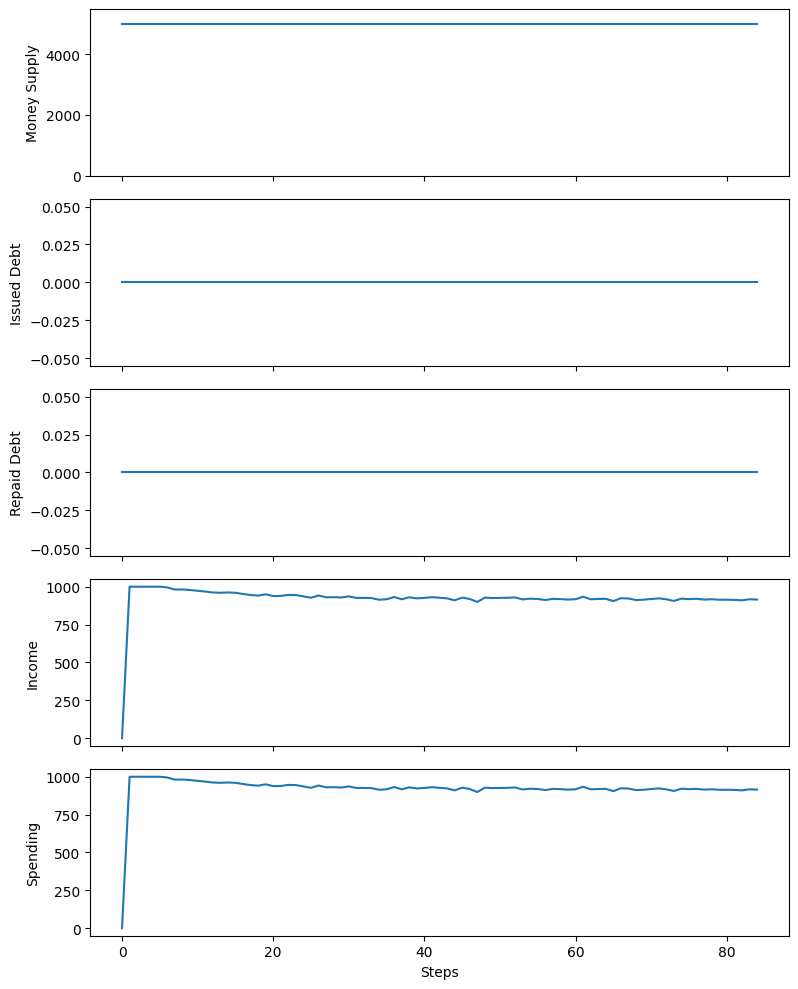

In [5]:
plot_model_data(no_loans_model)


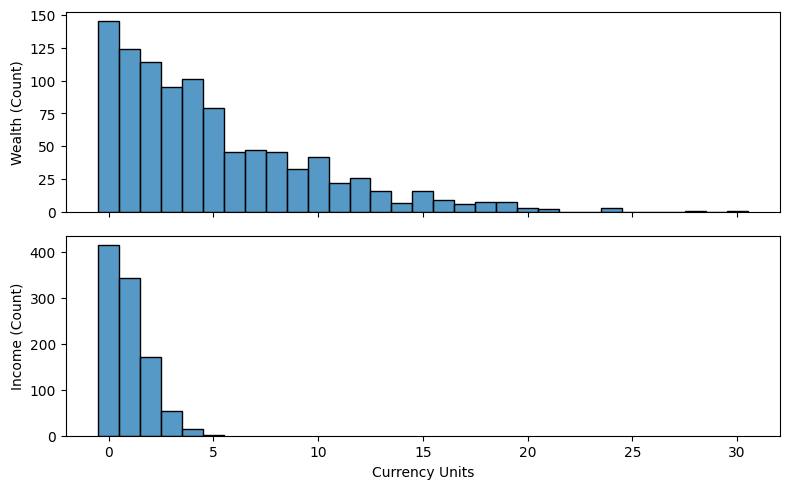

In [6]:
plot_individual_data(no_loans_model)



---

## 2. A model with loan applications

Now let's allow the bank to issue loans and thereby increase the amount of money available. Each individual will have a personal debt limit that caps the amount that they are willing to borrow. Whenever they don't have enough money to give some away and they are beneath their debt limit, they will apply for a loan from the bank. On its turn, the bank will review some number of loans and will issue liabilities for those it approves. (For now, the bank will approve all loans.)

The principal of the loans will be the minimum of the amount the individual needs for its spending, the amount of debt that they are able to take on, and a configurable maximum amount. The term (ie. duration) of the loan is also configurable.

In [7]:
loan_options = [
    {
        "term": 50,
    },
]

loans_model = BoltzmannBank(
    num_individuals = 1_000,
    borrowing_limit = 5,
    loan_review_limit = 50,
    loan_options=loan_options,
)

for _ in range(100):
    loans_model.step()

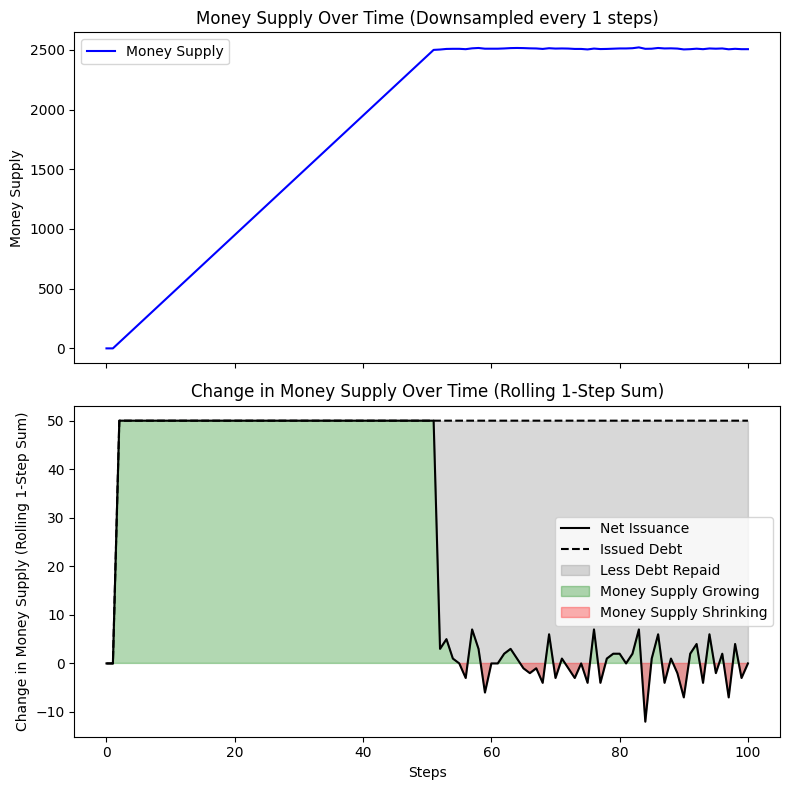

In [8]:
plot_money_supply(loans_model, period=1)

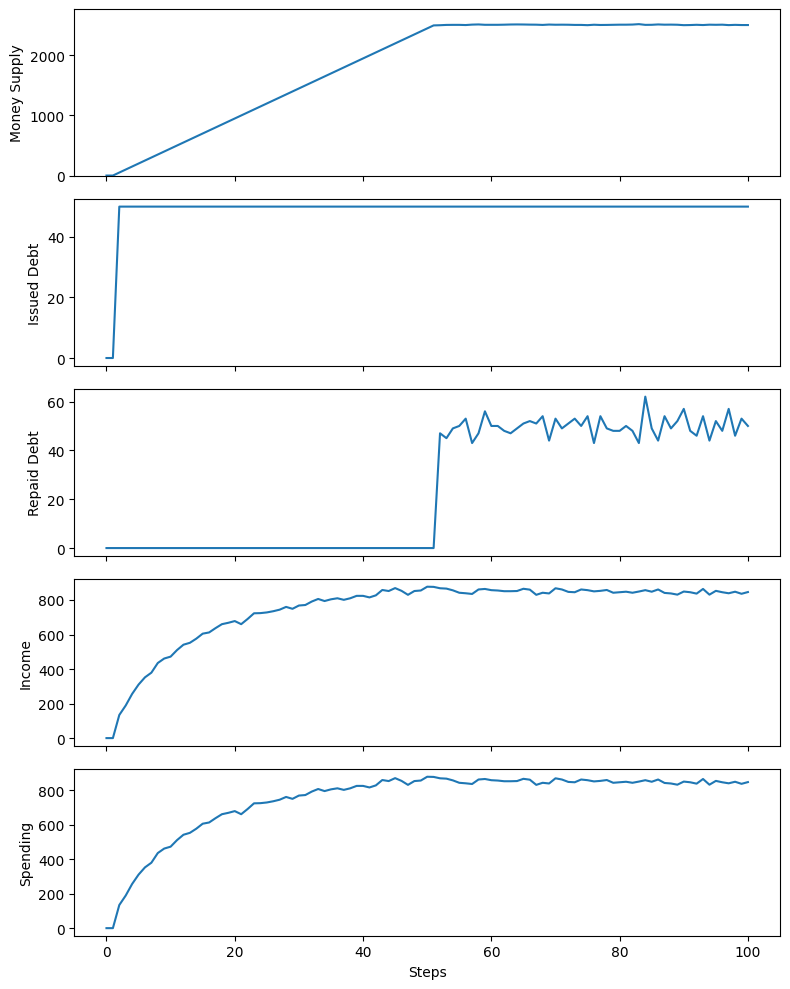

In [9]:
plot_model_data(loans_model)

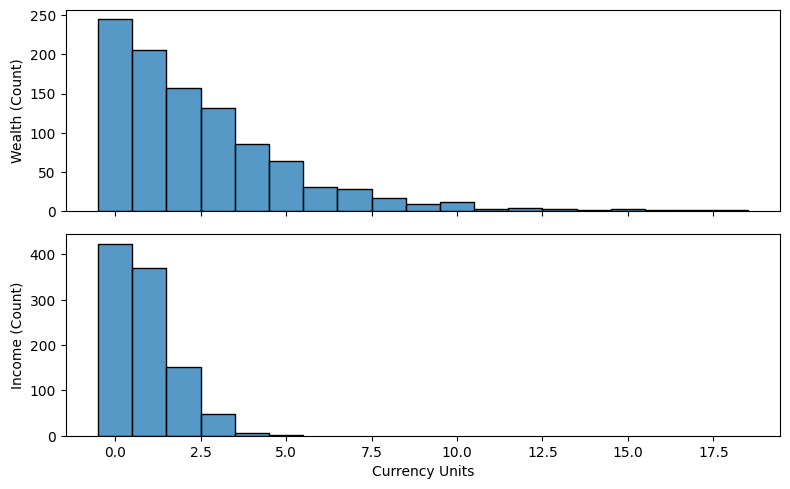

In [10]:
plot_individual_data(loans_model)


---

## 3. A model with multiple banks

Now let's try to expand our model by incorporating multiple banks linked through a reserve bank.

In [11]:
loan_options = [
    {
        "term": 50,
    },
]

multibank_model = BoltzmannBank(
    num_individuals = 100,
    num_banks=2,
    borrowing_limit = 1,
    loan_review_limit = 10,
    loan_options=loan_options,
)

for _ in range(100):
    multibank_model.step()

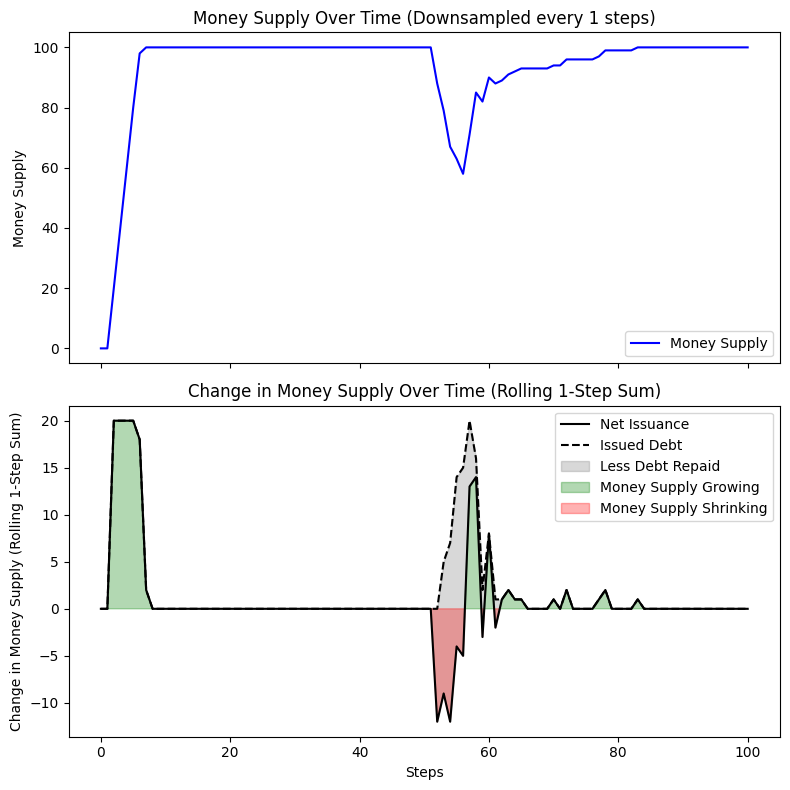

In [12]:
plot_money_supply(multibank_model)